<a href="https://colab.research.google.com/github/rasecotineb/datascience/blob/master/time-series/ModeloVAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo VAR


In [ ]:
import pandas as pd
import numpy as np
import random
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
plt.rcParams['figure.figsize'] = [10, 8]  #por defecto las figuras se displayan 8 pulgadas de ancho y 6 de alto

# VAR

Abajo se presenta un ejemplo de construcción de modelo VAR para el dataset <b>macrodata</b> provisto en statsmodels.api.   Dicho dataset tiene 14 variables económicas de USA a una resolución trimestral recolectadod por la FRED. Para este ejemplo se trabajará solo con 3 variables:

    * realgdp:   Producto interno bruto real de EEUU (Bil. USD encadenados de 2005, tasa anual desestacionalizada)
    * realcons:  Gastos reales de consumo personal  (Bil. USD encadenados de 2005, tasa anual desestacionalizada)
    * realinv:   Inversión interna privada bruta real (Bil. USD encadenados de 2005, tasa anual desestacionalizada)
    
Mayor informacion puede ser encontrada en https://www.statsmodels.org/dev/datasets/generated/macrodata.html


In [ ]:
# Librerias a usar
import numpy as np
import pandas
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.base.datetools import dates_from_str

# Lee la data
mdata = sm.datasets.macrodata.load_pandas().data

# prepara el indice temporal
dates = mdata[['year', 'quarter']].astype(int).astype(str)
quarterly = dates["year"] + "Q" + dates["quarter"]
quarterly = dates_from_str(quarterly)

# extrae las 3 variables que se trabajará y coloca el indice temporal
mdata = mdata[['realgdp','realcons','realinv']]
mdata.index = pandas.DatetimeIndex(quarterly)

# Retira la tendencia haciendo diferencias y aplica transformacion logaritmica para estacionarizar la varianza 
data = np.log(mdata).diff().dropna()

# Instancia el modelo VAR
model = VAR(data)

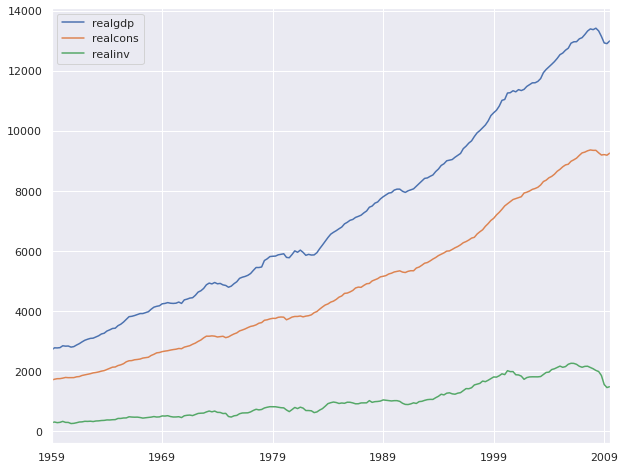

In [ ]:
# plotea las variables originales (sin transformar)
mdata.plot()
plt.show()

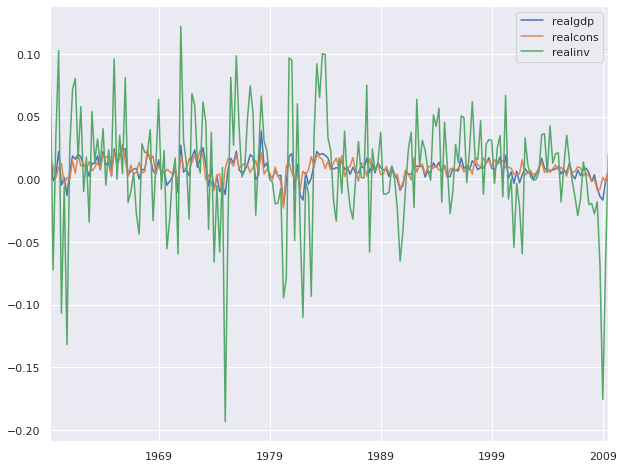

In [ ]:
# Plotea la data transformada (sin tendencias y estacionarizada en varianza)
data.plot()
plt.show()

In [ ]:
# Computa varios VAR  (hasta 10 lags) e informa las configuraciones con mejores valores de criterios de Informacion  
print(model.select_order(10))

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 1, BIC -> 1, FPE -> 1, HQIC -> 1>


In [ ]:
# Ajusta un modelo VAR con p=1 (fue el lag con mejores criterios AIC, BIC)
model_fit = model.fit(1)

In [ ]:
# Sumariza el modelo ajustado
model_fit.summary()


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 16, Sep, 2020
Time:                     21:36:30
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -27.7388
Nobs:                     201.000    HQIC:                  -27.8562
Log likelihood:           1963.94    FPE:                7.37174e-13
AIC:                     -27.9360    Det(Omega_mle):     6.94859e-13
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.003580         0.000911            3.928           0.000
L1.realgdp         -0.338056         0.172084           -1.964           0.049
L1.realcons         0.746283         0.130411            5.723    

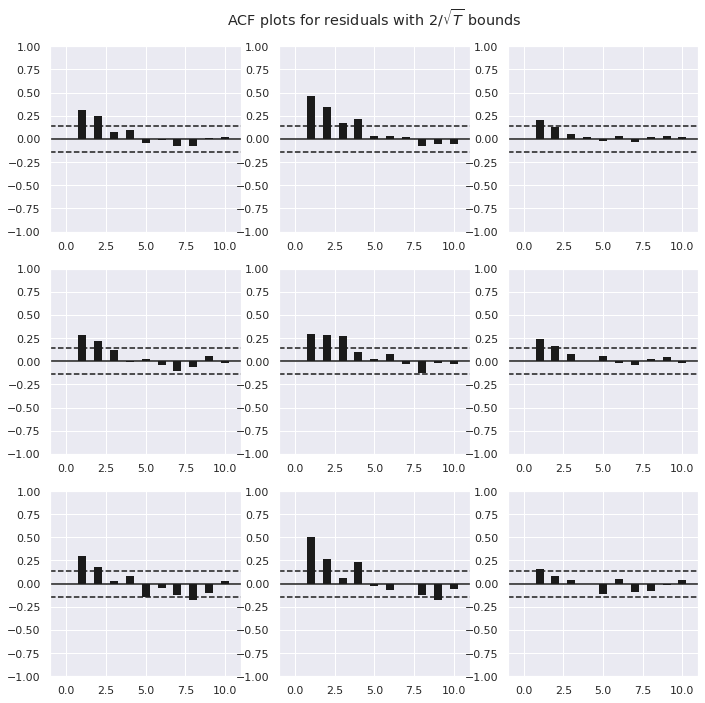

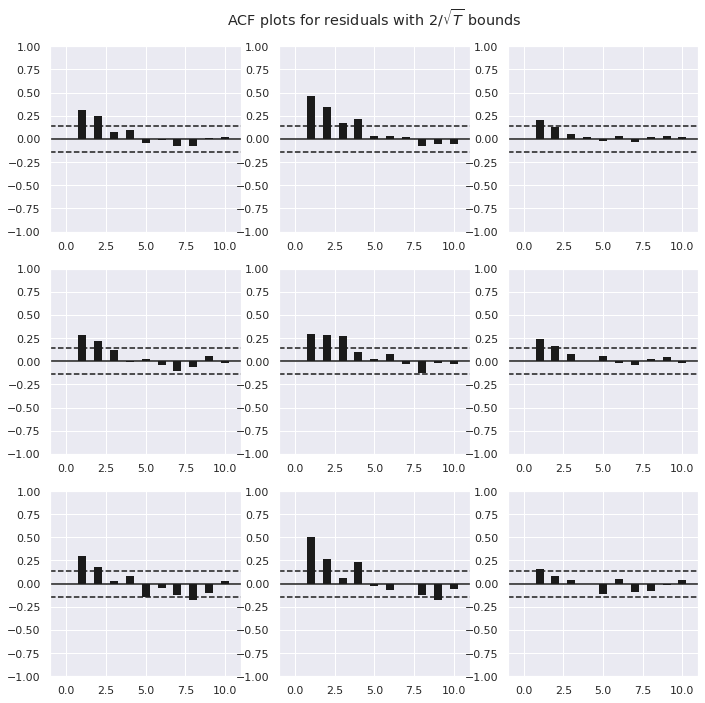

In [ ]:
# Plotea autocorrelación y crosscorrelacion de los residuos (para ver si vale la pena un VARMA) 
model_fit.plot_acorr(resid=False)

In [ ]:
# predice el siguiente punto temporal en las 3 variables (hay que proporcionarle la data histórica y el numero de steps)
y_predicted = model_fit.forecast(data.values[-1:], 1)

In [ ]:
data.values[-2:]

array([[-0.00185125, -0.00219587, -0.06756147],
       [ 0.00686219,  0.00726487,  0.02019724]])

In [ ]:
y_predicted

array([[0.00785158, 0.00860589, 0.00834729]])

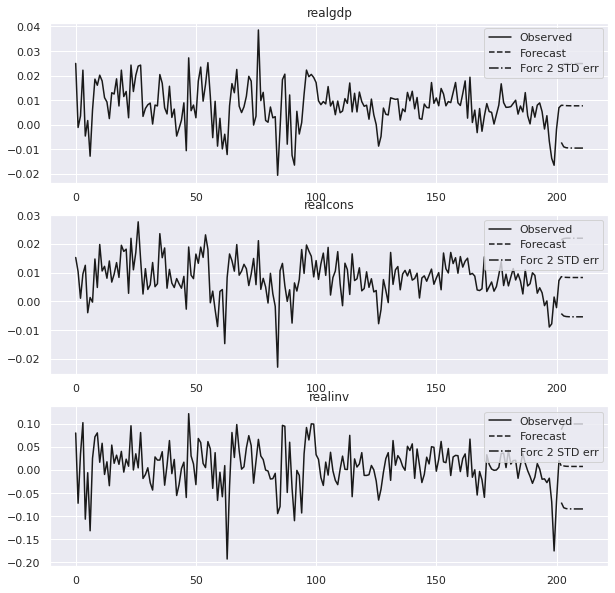

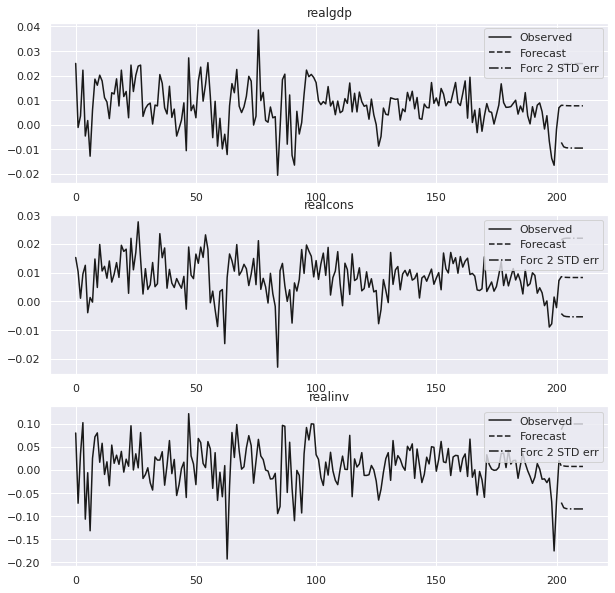

In [ ]:
# predice los siguientes 50 puntos (es predicción encadenada, no es walk-forwad ) 
model_fit.plot_forecast(10)

## Se busca

- Implementar la evaluacion en walk-forward del modelo VAR en el dataset <b>macrodata</b>  usando los 50 ultimos puntos como test. Calcular el rmse de cada variable
- Comparar con modelos AR ajustados individualmente en cada una de las variables individualmente 
    


###VAR walk-forward

In [ ]:
import warnings
from sklearn.metrics import mean_squared_error   # para calcular el error cuadratico medio
from math import sqrt
warnings.filterwarnings("ignore")   # para evitar que muestre constantemente advertencias

#50 registros para el test
train,test = data[0:-50],data[-50:]

historia=train
predicciones = pd.DataFrame()
# evaluación walk-forward
for i in range(len(test)):
# Instancia el modelo VAR con la historia
  modelo_wf = VAR(historia)
# Computa varios VAR  (hasta 10 lags) e informa las configuraciones con mejores valores de criterios de Informacion  
#  print(modelo_wf.select_order(10))
# Ajusta un modelo VAR con p=1 (fue el lag con mejores criterios AIC, BIC)
  modelo_wf_fit = modelo_wf.fit(1)
# predice el siguiente punto temporal en las 3 variables (hay que proporcionarle la data histórica (solo un lag, en este caso) y el numero de steps (=1))
  y_predicted = model_fit.forecast(historia.values[-1:], 1)  
  predicciones = predicciones.append(pd.DataFrame(y_predicted), ignore_index = True)
  historia=historia.append(test.iloc[i])

# evalua el RMSE para las 50 predicciones por cada variable
for j in range(0,3):
 rmse = sqrt(mean_squared_error(test.iloc[:,j], predicciones[j]))
 print('RMSE walk-forward en test: %.3f' % rmse,'en variable',test.columns[j])



RMSE walk-forward en test: 0.005 en variable realgdp
RMSE walk-forward en test: 0.005 en variable realcons
RMSE walk-forward en test: 0.031 en variable realinv


###Modelo AR - Variable realgdp

In [ ]:
from statsmodels.tsa.ar_model import AR
# entrena un modelo AR
ar_model = AR(train.iloc[:,0])
ar_model_fit =  ar_model.fit()

# imprime el orden encontrado (p) del modelo y sus coeficientes
p = ar_model_fit.k_ar
coef = ar_model_fit.params
print('Orden p del modelo AR: %s' % p)
print('Coeficientes del modelo AR: %s' % ar_model_fit.params)

Orden p del modelo AR: 13
Coeficientes del modelo AR: const          0.007270
L1.realgdp     0.231303
L2.realgdp     0.149484
L3.realgdp    -0.001402
L4.realgdp     0.085907
L5.realgdp    -0.145159
L6.realgdp     0.015358
L7.realgdp    -0.082977
L8.realgdp    -0.076529
L9.realgdp     0.085405
L10.realgdp    0.037371
L11.realgdp    0.042775
L12.realgdp   -0.159560
L13.realgdp   -0.061252
dtype: float64


In [ ]:
# Funcion para predecir el siguiente valor con los coeficientes de un modelo AR y una lista de observaciones históricas
def predict(coef, history):
    y_predicted = coef[0]
    for i in range(1, len(coef)):
        y_predicted += coef[i] * history[-i]
    return y_predicted

# hace las predicciones en test
history = pd.Series(train.iloc[:,0]).tolist()

predictions = list()
for t in range(len(test)):
    y_predicted = predict(coef, history)
    predictions.append(y_predicted)
    history.append( pd.Series(test.iloc[t,0]) )  # se añade la ultima observacion real al histórico (al estilo walk-forward)     
        
rmse = sqrt(mean_squared_error(test.iloc[:,0], predictions))
print('RMSE en test: %.3f' % rmse)

RMSE en test: 0.006


###Modelo AR - Variable realinv

In [ ]:
from statsmodels.tsa.ar_model import AR
# entrena un modelo AR
ar_model = AR(train.iloc[:,2])
ar_model_fit =  ar_model.fit()

# imprime el orden encontrado (p) del modelo y sus coeficientes
p = ar_model_fit.k_ar
coef = ar_model_fit.params
print('Orden p del modelo AR: %s' % p)
print('Coeficientes del modelo AR: %s' % ar_model_fit.params)

Orden p del modelo AR: 13
Coeficientes del modelo AR: const          0.015125
L1.realinv     0.121926
L2.realinv     0.024356
L3.realinv     0.031773
L4.realinv    -0.041421
L5.realinv    -0.237172
L6.realinv     0.099812
L7.realinv    -0.131871
L8.realinv    -0.082745
L9.realinv    -0.051703
L10.realinv    0.025282
L11.realinv    0.025997
L12.realinv   -0.154502
L13.realinv   -0.070605
dtype: float64


In [ ]:
# Funcion para predecir el siguiente valor con los coeficientes de un modelo AR y una lista de observaciones históricas
def predict(coef, history):
    y_predicted = coef[0]
    for i in range(1, len(coef)):
        y_predicted += coef[i] * history[-i]
    return y_predicted

# hace las predicciones en test
history = pd.Series(train.iloc[:,1]).tolist()

predictions = list()
for t in range(len(test)):
    y_predicted = predict(coef, history)
    predictions.append(y_predicted)
    history.append( pd.Series(test.iloc[t,1]) )  # se añade la ultima observacion real al histórico (al estilo walk-forward) 
        
rmse = sqrt(mean_squared_error(test.iloc[:,1], predictions))
print('RMSE en test: %.3f' % rmse)

RMSE en test: 0.005


###Modelo AR - Variable realinv

In [ ]:
from statsmodels.tsa.ar_model import AR
# entrena un modelo AR
ar_model = AR(train.iloc[:,2])
ar_model_fit =  ar_model.fit()

# imprime el orden encontrado (p) del modelo y sus coeficientes
p = ar_model_fit.k_ar
coef = ar_model_fit.params
print('Orden p del modelo AR: %s' % p)
print('Coeficientes del modelo AR: %s' % ar_model_fit.params)

Orden p del modelo AR: 13
Coeficientes del modelo AR: const           0.005771
L1.realcons     0.187921
L2.realcons     0.173223
L3.realcons     0.176754
L4.realcons    -0.064553
L5.realcons    -0.063751
L6.realcons     0.096380
L7.realcons    -0.073390
L8.realcons    -0.154263
L9.realcons     0.021068
L10.realcons    0.064132
L11.realcons    0.045587
L12.realcons   -0.099317
L13.realcons    0.027376
dtype: float64


In [ ]:
# Funcion para predecir el siguiente valor con los coeficientes de un modelo AR y una lista de observaciones históricas
def predict(coef, history):
    y_predicted = coef[0]
    for i in range(1, len(coef)):
        y_predicted += coef[i] * history[-i]
    return y_predicted

# hace las predicciones en test
history = pd.Series(train.iloc[:,2]).tolist()

predictions = list()
for t in range(len(test)):
    y_predicted = predict(coef, history)
    predictions.append(y_predicted)
    history.append( pd.Series(test.iloc[t,2]) )  # se añade la ultima observacion real al histórico (al estilo walk-forward) 
        
rmse = sqrt(mean_squared_error(test.iloc[:,2], predictions))
print('RMSE en test: %.3f' % rmse)

RMSE en test: 0.036
